In [1]:
import pandas as pd
from database import select_dataset
import numpy as np

In [2]:
# FIND WAY TO WRAP THIS CLEANLY CAUSE IT's A MESS !

aquastat = select_dataset('aquastat').dropna()
evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()
cropcalendar = select_dataset('cropcalendar').drop(columns=['Year'])
efficientwater = select_dataset('efficientwater')
wb_data = select_dataset('worldbank')

In [3]:
def pivot(df):
    return df.pivot(index=['ISO', 'Year'], columns='Variable', values='Value')

def fill_missing_values(df):
    return df.groupby(level='ISO').fillna(method='ffill')\
             .groupby(level='ISO').fillna(method='bfill')

def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X

In [4]:
def process_datasets(aquastat, efficientwater, wb_data,  evapotranspiration, cropcalendar):
    '''To cleanup !!! '''
    
    aquastat = aquastat[~aquastat.ISO.isin(['USA', 'CHN', 'IND', 'RUS'])] # Not parsed !
    aquastat = aquastat[aquastat.Variable != 'CI']
    aquastat['Year'] = aquastat['Year'].astype(int)
    wb_data['Year'] = wb_data['Year'].astype(int)
    
    aquastat = fill_missing_values(pivot(aquastat))
    evapotranspiration = pivot(evapotranspiration)
    ETa = fill_missing_values(evapotranspiration['ETa'])
    ETo = evapotranspiration['ETo'].reset_index('Year', drop=True).dropna()
    cropcalendar = cropcalendar.pivot(index=['ISO', 'Item'], columns='Variable', values='Value')
    wb_data = pivot(wb_data)
    efficientwater = pivot(efficientwater)

    X = df_to_dict(aquastat)
    
    gva = df_to_dict(wb_data)
    ew = df_to_dict(efficientwater)
    
    X.update(gva)
    X.update(ew)
    
    X['ETa'] = ETa
    X['ETo'] = ETo
    X['LWU'] = 0
    X['KC'] = cropcalendar['Kc']
    X['ICA'] = cropcalendar['ICA']
    
    
    return X

In [5]:
data_dict = process_datasets(aquastat, efficientwater, wb_data,  evapotranspiration, cropcalendar)

# Model

In [6]:
from graphmodels.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np
from graphmodels.validation import check_model, check_variable_graph
from models.Sarah.model_EW import EW_models, MWU_model
from graphmodels.utils import get_X_y_from_data

In [7]:
for model_name, model in EW_models.items():
    print(model_name, ': ')
    X, y = get_X_y_from_data(model, data_dict)
    check_model(model, X, y)

IWW_model : 
Checking computations:
IWR r2: -0.12665142623068482 | IWR corr: 0.9379986749670274
IWW r2: -4.205209733188055 | IWW corr: 0.4184869553410477
AWU r2: -0.0628858927658491 | AWU corr: 0.9135028659380573
EW1_partial_model : 
Checking computations:
TWW r2: 0.9899453815126853 | TWW corr: 0.9949795916522841
EW1 r2: -1.3182233892117088 | EW1 corr: 0.49113714674572345
EW2_partial_model : 
Checking computations:
EW1_model : 
Checking computations:


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


IWR r2: -0.12665142623068482 | IWR corr: 0.9379986749670274
IWW r2: -4.205209733188055 | IWW corr: 0.4184869553410477
AWU r2: -0.0628858927658491 | AWU corr: 0.9135028659380573
MWU r2: 0.8857802007650846 | MWU corr: 0.9454090865744061
TWW r2: 0.18568915784345286 | TWW corr: 0.9041843786599282
EW1 r2: 0.3718408837210735 | EW1 corr: 0.6705142872178541
EW2_model : 
Checking computations:
IWR r2: -0.12665142623068482 | IWR corr: 0.9379986749670274
IWW r2: -4.205209733188055 | IWW corr: 0.4184869553410477
AWU r2: -0.0628858927658491 | AWU corr: 0.9135028659380573


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


MWU r2: 0.8857802007650846 | MWU corr: 0.9454090865744061


# Test on model

In [47]:
WP = data_dict['WP']
GDPC = data_dict['GDPC']
Pop = data_dict['Pop']
MWU = data_dict['MWU']

scenario_df = pd.concat([WP, GDPC, Pop, MWU], axis=1).rename(columns={0: 'GDPC'}).reset_index()
ISO_scenario_df = scenario_df.query("ISO == 'FRA' and Year > 2005")\
                             .fillna(method='ffill')\
                             .fillna(method='bfill')

X = df_to_dict(ISO_scenario_df.set_index(['ISO', 'Year']))

In [48]:
MWU_comp = MWU_model.run(X)['MWU']

In [49]:
ISO_scenario_df['MWU_comp'] = MWU_comp.values

In [50]:
ISO_scenario_df

,ISO,Year,WP,GDPC,Pop,MWU,MWU_comp
4548,FRA,2006,2.18,40850.355530,63621381.0,5.683,7.989722
4549,FRA,2007,2.18,41582.799705,64016225.0,5.683,8.123610
4550,FRA,2008,2.18,41456.483420,64374984.0,5.683,8.153801
4551,FRA,2009,2.18,40058.679760,64707040.0,5.683,8.030574
4552,FRA,2010,2.18,40638.334004,65027507.0,5.683,8.138699
4553,FRA,2011,2.18,41329.035361,65342780.0,5.683,8.259585
4554,FRA,2012,2.18,41258.274731,65659809.0,5.380,8.290683
4555,FRA,2013,2.18,41282.990800,65998687.0,5.380,8.335825
4556,FRA,2014,2.18,41480.769608,66312067.0,5.380,8.398574
4557,FRA,2015,2.18,41793.544712,66548272.0,5.380,8.465626


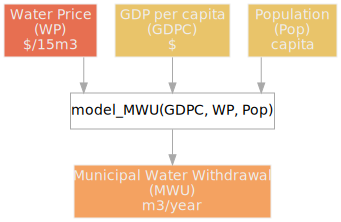

In [13]:
MWU_model.draw()

In [14]:
aquastat.query("Variable == 'MWU'")

,Area,Year,Value,ISO,Variable,Description,Unit
8606,Afghanistan,2000.0,0.1542,AFG,MWU,Municipal water withdrawal,10^9 m3/yr
8607,Afghanistan,2005.0,0.2034,AFG,MWU,Municipal water withdrawal,10^9 m3/yr
8608,Albania,1990.0,0.1000,ALB,MWU,Municipal water withdrawal,10^9 m3/yr
8609,Albania,2000.0,0.5504,ALB,MWU,Municipal water withdrawal,10^9 m3/yr
8610,Albania,2005.0,0.5613,ALB,MWU,Municipal water withdrawal,10^9 m3/yr
...,...,...,...,...,...,...,...
9193,Zambia,1994.0,0.2700,ZMB,MWU,Municipal water withdrawal,10^9 m3/yr
9194,Zambia,2000.0,0.2900,ZMB,MWU,Municipal water withdrawal,10^9 m3/yr
9195,Zimbabwe,2002.0,0.5890,ZWE,MWU,Municipal water withdrawal,10^9 m3/yr
9196,Zimbabwe,2007.0,0.4250,ZWE,MWU,Municipal water withdrawal,10^9 m3/yr
